In [46]:
import sklearn
import catboost
import shap

import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.feature_selection import RFECV
from scipy.stats import kstest, norm
import matplotlib.pyplot as plt
from base_functions import r #np.round wrap
 
import base_functions

In [131]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [132]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

# Criação do dataset analítico final

Nessa seção iremos fazer os seguintes processos:
- importar o csv criado no arquivo anterior
- elimina valores faltantes do target
- agrupa os dados por estudante/modulo/semestre.
- cria dummies para variáveis categoricas
- separa grupo de treino e teste


In [2]:
# Import data created on the 01_etl.ipynb file
df = pd.read_csv("base_data.csv")

In [3]:
df['assessment_type'].value_counts()

TMA     98306
CMA     70480
Exam     4958
Name: assessment_type, dtype: int64

In [4]:
# I understand that doesn't make sense to keep rows without a final score, since it doesn't serve
# us neither for the training nor for the validation of the model.
df = df.dropna(subset=['score'])

In [5]:
# Split the lines that summarize the grades.
target_data = df.query("assessment_type == 'Exam'")
training_data = df.query("assessment_type != 'Exam'")

In [6]:
target_data = target_data[['id_student', 'code_module', 'code_presentation', 'score']]

In [7]:
# Here we aggregate the data in the granularity level we intend to use.
training_data = training_data[[
    'id_student',
    'code_module',
    'code_presentation',
    'score', 
    'gender',
    'region',
    'highest_education',
    'imd_band',
    'age_band', 
    'num_of_prev_attempts', 
    'studied_credits', 
    'disability',
    'sum_click',
    'module_presentation_length',
    'date_registration',
    'date_unregistration'
] ].groupby([
    'id_student',
    'code_module',
    'code_presentation']).agg({
    'gender': 'last',
    'region': 'last',
    'highest_education': 'last',
    'imd_band': 'last',
    'age_band': 'last',
    'num_of_prev_attempts': 'last',
    'studied_credits': 'sum',
    'disability': 'last',
    'sum_click': ['sum'],
    'module_presentation_length' : ['sum'],
    'date_registration': 'sum',
})

# We don't use the intermediate grade variables since I understand
# that they present an information leakage with the target.

In [8]:
# Merge the target with the grouped data on the [student/module/semester] level.
pre_encoded_final_data = training_data.merge(target_data, on=['id_student', 'code_module', 'code_presentation'])

/home/leonardofavaretto/.local/lib/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [9]:
# Transform categorical variables in dummies.
encoded_data = pd.get_dummies(pre_encoded_final_data).set_index('id_student')

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Split data in train and test group.
X_train, X_test, y_train, y_test = train_test_split(
    encoded_data.drop('score', 1),
    encoded_data['score'],
    test_size=0.33,
    random_state=42)

Agora que temos um dataset analítico no nível de agregação desejado, iremos executar uma triagem entre modelos. Os modelos triados são 7:

1. **Regressão lasso**
2. **Random forest**
3. **Support vector machine**
4. **Regressão linear estimada com OLS (ordinary least squares)**
5. **Gradient boosting**
6. **Extra trees**
7. **Árvore de decisão**

In [326]:
# Models to be used
lasso = sklearn.linear_model.Lasso()
dt = sklearn.tree.DecisionTreeRegressor()
rf = sklearn.ensemble.RandomForestRegressor()
svm = sklearn.svm.SVR()
lr = sklearn.linear_model.LinearRegression()
gb = sklearn.ensemble.GradientBoostingRegressor()
et = sklearn.ensemble.ExtraTreesRegressor()

In [327]:
models_list = [lasso, dt, rf, svm, lr, gb, et]

In [298]:
# Trial the selected models
list_ = []

feat_imp = []

for model in models_list:
    model_ = model.fit(X_train, y_train)
    y_pred = model_.predict(X_test)
    
    dict_ = {'r2': metrics.r2_score(y_test, y_pred),
             'MAE': metrics.median_absolute_error(y_test, y_pred),
             'ME': metrics.mean_absolute_error(y_test, y_pred),
             'SQR': metrics.mean_squared_error(y_test, y_pred)}
    
    list_.append(dict_)
    

metrics_df = pd.DataFrame(list_)    

In [299]:
model_names = [f"{i}" for i in models_list]

metrics_df.index = model_names

# Create metric (MRSE) used to tune the model, in order to have a direct benchmarking
 # between the raw models and the tunned model.
metrics_df['MRSE'] = np.sqrt(metrics_df['SQR'])

### Métricas

In [302]:
metrics_df

,r2,MAE,ME,SQR,MRSE
Lasso(),0.051089,14.732396,16.326522,388.897394,19.720482
DecisionTreeRegressor(),-0.746210,18.000000,21.338631,715.658924,26.751802
RandomForestRegressor(),0.093257,14.125000,15.726186,371.615533,19.277332
SVR(),0.030822,14.774723,16.543467,397.203487,19.929965
LinearRegression(),0.126216,14.007085,15.501671,358.107630,18.923732
GradientBoostingRegressor(),0.134928,13.621874,15.419374,354.537126,18.829156
ExtraTreesRegressor(),0.026784,14.180000,16.222592,398.858361,19.971439


***Podemos observar que o modelo de GradientBoosting foi superior em todas as métricas observadas***, e doravante será o modelo utilizado. Na triagem, utilizamos as implementações da biblioteca sklearn pela sua homegeneidade na utilização. A partir de agora utilizaremos a biblioteca **catboost**, que é uma implementação mais eficiente do mesmo algoritmo.

Uma vez que escolhemos um modelo base, iremos fazer o ajuste de alguns parâmetros.

### Grid Search

In [303]:
# grid of parameters
grid = {'l2_leaf_reg': [0.01, 0.05, 0.1, 0.2, 2],
       'depth': [3, 4, 5, 6, 7, 8, 9, 10],
       'learning_rate': [0.1, 0.05, 0.02, 0.01, 0.001]
       }
# this object is used just for documentation purposes
loss_function_to_test = ['RMSE', 'MAE', 'MAPE'],

In [ ]:
# The base model for the grid search
cb = catboost.CatBoostRegressor(random_seed=1)

In [156]:
grid_search = cb.grid_search(param_grid=grid,
                             X=X_train,
                             y=y_train,
                             cv=3,
                             plot=True,
                             verbose=False)

In [12]:
# Here we re-instantiate the model with the parameters selected.
cb = catboost.CatBoostRegressor(random_seed=1,
                                thread_count=6,
                                l2_leaf_reg=0.01,
                                depth=7,
                                learning_rate=0.009
                               )

In [13]:
cb.fit(X_train, y_train, metric_period=1000)

0:	learn: 20.7210611	total: 49.4ms	remaining: 49.4s
999:	learn: 15.8112906	total: 2.24s	remaining: 0us


In [14]:
y_predicted = cb.predict(X_test)

In [15]:
base_functions.return_metrics(y_test, y_predicted)

{'mse': 18.70383325946848,
 'r2': 0.14640537483012228,
 'mae': 13.500044733832535,
 'me': 15.314897235528184,
 'mape': 31.064055061188828}

Após o ajuste dos parâmetros, observamos uma leve melhora nas métricas de performance em relação ao modelo inicial.

# Seleção de Variáveis

Nesse estágio iremos ver se é possível eliminar alguma variável, obtendo assim um modelo com o potencial preditivo maior ou igual, mas com menos variáveis. Para isso faremos uma remoção aleatória de variáveis com validação cruzada.

In [242]:
# Feature Selection [RANDOM FEATURE ELIMINATION WITH CROSS VALIDATION]
selector = RFECV(cb, step=1, cv=3, verbose=0, n_jobs=6)
selector = selector.fit(X_test, y_test)
# The logs of the process were omitted because they are too verbose 

O procedimento sugeriu a **remoção** das variáveis:

- "disability_N"
- "highest_education_No Formal quals"

Todavia a reexecução do modelo sem essas variáveis resultou em uma piora significativa das métricas, e por isso elas foram mantidas.

# Interpretação das variáveis

In [16]:
cb.get_feature_importance(prettified=True)

,Feature Id,Importances
0,"('sum_click', 'sum')",15.972644
1,"('module_presentation_length', 'sum')",9.871449
2,"('date_registration', 'sum')",9.108206
3,"('studied_credits', 'sum')",7.349202
4,"('highest_education', 'last')_Lower Than A Level",6.804813
5,code_presentation_2013B,4.214519
6,"('highest_education', 'last')_HE Qualification",3.030417
7,code_presentation_2014B,2.888974
8,"('region', 'last')_North Region",2.728510
9,"('num_of_prev_attempts', 'last')",2.655405


Vemos que as variáveis com maior poder explicativo são o número de clickes no VLE, representando a interação do estudante com o material de estudo, e o número de horas dedicadas a apresentação do módulo. As duas variáveis seguintes em importância são a antecedência com que os estudantes se matricularam no curso em relação a data de início, e o número de créditos nos quais o estudante está correntemente matriculado. <br>
Agora iremos analizar a direção do impacto das variáveis nas predições utilizando a metodologia de Shapley Additive Explanations (https://github.com/slundberg/shap):

In [153]:
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(cb)
shap_values = explainer.shap_values(X_test)


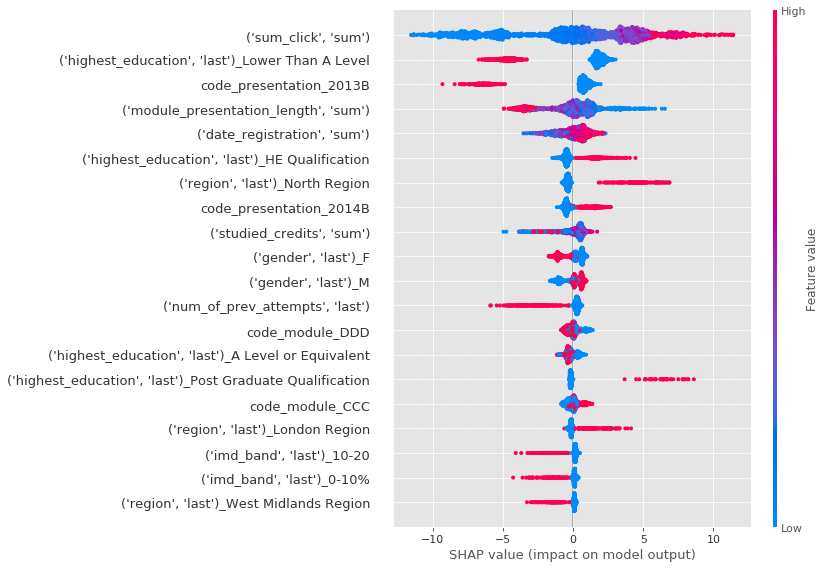

In [154]:
shap.summary_plot(shap_values, X_test)

O gráfico nos permite ver que estudantes com ambos menos cliques e matrícula em menos créditos possuem notas menores em média, ao tempo que cursos com apresentações maiores estão associados a menores notas, e maiores antecedências na matrícula a notas maiores.

# Análise do erro e considerações finais.

In [17]:
import seaborn as sn

In [43]:
erro = y_predicted - y_test

In [146]:
print('mean error: ', r(np.mean(erro)))
print('std error: ', r(np.std(erro)))

mean error:  0.27
std error:  18.7


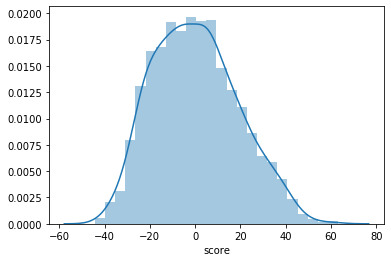

In [44]:
sn.distplot(erro)

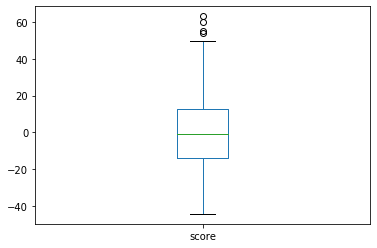

In [45]:
erro.plot(kind='box')

In [147]:
ks_statistic, p_value = kstest(erro, 'norm')
print("p_value: ", p_value)

p_value:  0.0


Observamos que o erro é assimétrico à direita, e decai exponencialmente na medida que se afasta da média de forma similar a uma distribuição normal, todavia com a calda mais longa, estando a maioria das observações em até 4 desvios padrão da media, ao invés dos 3 característicos da normal. A média do erro de 0.23 também denuncia essa leve assimetria. Um teste ks rejeita facilmente a hipótese nula de a distribuição em questão ter uma distribuição normal. O entendimento do viés do modelo é importante no entendimento de como aplicar a estimativa à uma regra de neǵocio.

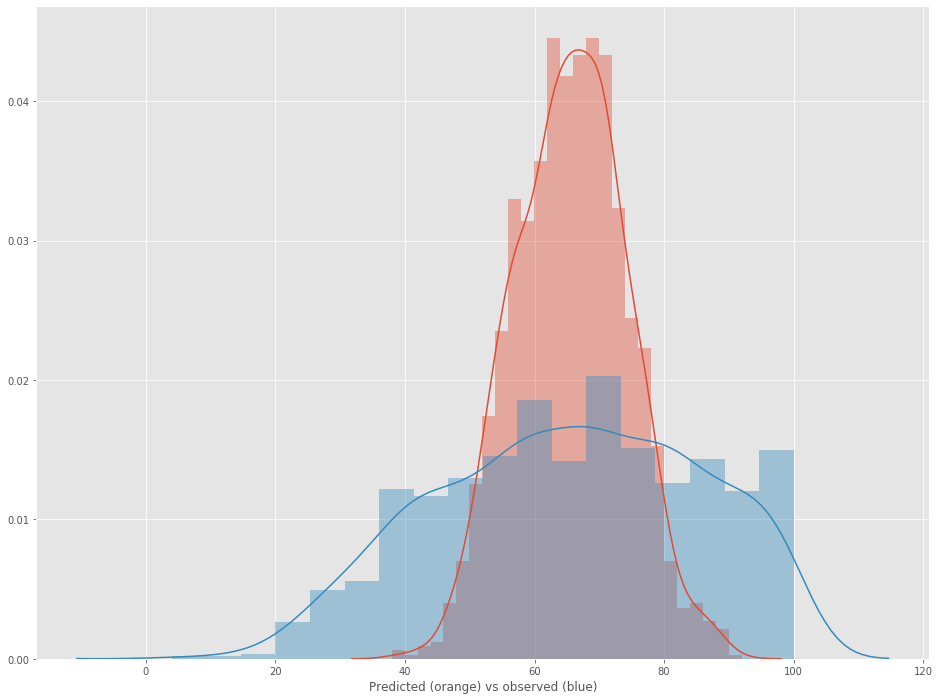

In [86]:
sn.distplot(pd.Series(y_predicted))
sn.distplot(pd.Series(y_test, name="Predicted (orange) vs observed (blue)"))

In [151]:
print('predicted std: ', r(np.std(y_predicted)))
print('predicted mean: ', r(np.mean(y_predicted)))
print('predicted median: ', r(np.median(y_predicted)))

print("==========================")

print('observed std: ', r(np.std(y_test)))
print('observed mean: ', r(np.mean(y_test)))
print('observed median: ', r(np.median(y_test)))

print("==========================")

predicted std:  8.51
predicted mean:  65.64
predicted median:  65.84
observed std:  20.24
observed mean:  65.36
observed median:  67.0


Observamos inicialmente que os valores preditos pelo modelo tem uma variância significativamente inferior aos valores observados. Tal fato pode ser observado previamente pelo valor do r2 = SQE/SQT =~0.15, que já denotava essa diferença nas variâncias. Já as médias são virtualmente identicas, e a diferença na mediana expressa a diferença na calda esquerda, para qual a amostra observada possui valores entre 0 e 100, enquanto que a predita pelo modelo se restringe ao intervalo entre 30 e 100. Isso também explica em parte a diferença nas variâncias.

In [140]:
print("error smaller than 10 points is ", r((erro.abs() <= 10).sum() / len(erro) * 100), "%")
print("error smaller than 15 points is ", r((erro.abs() <= 15).sum() / len(erro) * 100), "%")
print("error smaller than 25 points is ", r((erro.abs() <= 25).sum() / len(erro) * 100), "%")

error smaller than 10 points is  38.02 %
error smaller than 15 points is  54.46 %
error smaller than 25 points is  81.54 %


Por fim, podemos sumarizar o potencial preditivo do modelo com a informação acima:
- 38% das predições erram até 10 pontos, em um intervalo de 0 a 100.
- 54% erram até 15 pontos.
- 81% erram até 25 pontos

Suponha que o objetivo do modelo é selecionar alunos para o recebimento de bolsas de estudos. Interpretando subjetivamente, esse modelo na versão apresentada tem um poder preditivo significativo, todavia não o suficiente para assumir completamente a tomada de decisão sobre a concessão de bolsas. Uma regra sugerida seria a aprovação automática para o quartil com as maiores notas preditas, e a recusa automática para os alunos do quartil inferior, **reduzindo a necessidade de análise humana em 50%**. Isso demonstra um fato observdo com frequência em campo: mesmo modelos com métricas medianas podem gerar um impacto econômico substancial.